# Training script

## Dependencies

In [9]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd

import imp
import os
import sys
import math
import time
import random
import shutil

from tqdm import tqdm
import numpy as np



In [10]:
print("cuda version is "+torch.version.cuda)

cuda version is 9.0.176


## Data processing and loading

### Categories mapping:

0 - background <br />
1 - boundary <br />
2 - cytoplasm <br />

In [11]:
import cv2
import random

class JointRandomCrop(object):
    """Crops the given list of images at random location to have a region of
    the given size. size can be a tuple (target_height, target_width)
    or an integer, in which case the target will be of a square shape (size, size)
    """

    def __init__(self, size, padding=0):
        if isinstance(size, int):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, imgs):
        h, w = imgs[0].shape
        th, tw = self.size
        if w == tw and h == th:
            return imgs

        x1 = random.randint(0, w - tw - 2)
        y1 = random.randint(0, h - th - 2)
        return [img[x1: x1 + tw, y1: y1 + th] for img in imgs]


class JointRandomHorizontalFlip(object):
    """Randomly horizontally flips the given list of PIL.Image with a probability of 0.5
    """

    def __call__(self, imgs):
        if random.random() < 0.5:
            return [cv2.flip(img, 1) for img in imgs]
        return imgs

In [12]:
# Data loader
import os
import os.path as op
from collections import namedtuple
from random import shuffle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch


Sample = namedtuple('Sample', ['boundary', 'cytoplasm', 'raw'])

class DataLoader(object):
    def __init__(self, data_dir, batch_size, shuffle=True, size=(224, 224)):
        self.data_dir = data_dir
        self.__find_images()
        self.batch_size = batch_size
        self.shuffle = shuffle
        if size is None:
            sample = cv2.imread(self.images[0].raw)
            self.size = (sample.shape[0], sample.shape[1])
        else:
            self.size = size
        self.transforms = [JointRandomCrop(self.size), JointRandomHorizontalFlip()]
        self.batch_num = int(np.ceil(len(self.images)) / float(batch_size))
        
    def __find_images(self):
        self.images = []
        subdirs = sorted(os.listdir(self.data_dir))
        for subdir in subdirs:
            abs_path = op.join(self.data_dir, subdir)
            self.images.append(Sample(op.join(abs_path, 'feature_0.png'),
                                      op.join(abs_path, 'feature_1.png'),
                                      op.join(abs_path, 'rawphase.png')))
    
    def __load_data(self, samples):
        inputs = np.zeros((len(samples), 1, self.size[0], self.size[1]))
        labels = np.zeros((len(samples), 3, self.size[0], self.size[1]))
        
        for i, sample in enumerate(samples):
            raw = cv2.imread(sample.raw, 0)
            boundary = cv2.imread(sample.boundary, 0)
            cytoplasm = cv2.imread(sample.cytoplasm, 0)
            
            # apply transforms
            for transform in self.transforms:
                raw, boundary, cytoplasm = transform([raw, boundary, cytoplasm])
            
            # Change values to binary
            boundary[np.where(boundary > 0)] = 1
            
            cytoplasm[np.where(cytoplasm > 0)] = 1
            cytoplasm[np.where(boundary > 0)] = 0
            
            background = np.ones(cytoplasm.shape)
            background -= (cytoplasm + boundary)
            
            labels[i, 0, ...] = background[:]
            labels[i, 1, ...] = boundary[:]
            labels[i, 2, ...] = cytoplasm[:]
            
            inputs[i, 0, ...] = raw[:]
            
        labels = np.argmax(labels, 1)
        return torch.from_numpy(inputs / 255.).float(), torch.from_numpy(labels).long()
    
    def __iter__(self):
        if self.shuffle:
            shuffle(self.images)
        for i in range(0, len(self.images), self.batch_size):
            yield self.__load_data(self.images[i: i+self.batch_size])

## Layers

In [13]:
import torch.nn as nn


def center_crop(layer, max_height, max_width):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/merge.py#L162
    #Author does a center crop which crops both inputs (skip and upsample) to size of minimum dimension on both w/h
    batch_size, n_channels, layer_height, layer_width = layer.size()
    xy1 = (layer_width - max_width) // 2
    xy2 = (layer_height - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]

class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        
        #author's impl - lasange 'same' pads with half 
        # filter size (rounded down) on "both" sides
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
                out_channels=growth_rate, kernel_size=3, stride=1, 
                  padding=1, bias=True))
        
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super(DenseLayer, self).forward(x)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super(DenseBlock, self).__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])
        
    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x 
    
class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super(TransitionDown, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
              out_channels=in_channels, kernel_size=1, stride=1, 
                padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))
        
    def forward(self, x):
        return super(TransitionDown, self).forward(x)
    
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels=in_channels, 
               out_channels=out_channels, kernel_size=3, stride=2, 
              padding=0, bias=True) #crop = 'valid' means padding=0. Padding has reverse effect for transpose conv (reduces output size)
        #http://lasagne.readthedocs.io/en/latest/modules/layers/conv.html#lasagne.layers.TransposedConv2DLayer
        #self.updample2d = nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out
    
class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(Bottleneck, self).__init__()
        self.add_module('bottleneck', DenseBlock(in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super(Bottleneck, self).forward(x)

## Model

In [14]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=1, down_blocks=(5,5,5,5,5), 
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=3):
        super(FCDenseNet, self).__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        
        cur_channels_count = 0
        skip_connection_channel_counts = []
        
        
        #####################
        # First Convolution #
        #####################

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels, 
                  out_channels=out_chans_first_conv, kernel_size=3, 
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv
        
        
        
        #####################
        # Downsampling path #
        #####################
        
        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))
            
            
            
        #####################
        #     Bottleneck    #
        #####################
        
        self.add_module('bottleneck',Bottleneck(cur_channels_count, 
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels 
        
        
        
        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i], 
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

            
        #One final dense block
        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1], 
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        
        
        #####################
        #      Softmax      #
        #####################

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count, 
               out_channels=n_classes, kernel_size=1, stride=1, 
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        #print("INPUT",x.size())
        out = self.firstconv(x)
        
        skip_connections = []
        for i in range(len(self.down_blocks)):
            #print("DBD size",out.size())
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
            
        out = self.bottleneck(out)
        #print ("bnecksize",out.size())
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            #print("DOWN_SKIP_PRE_UPSAMPLE",out.size(),skip.size())
            out = self.transUpBlocks[i](out, skip)
            #print("DOWN_SKIP_AFT_UPSAMPLE",out.size(),skip.size())
            out = self.denseBlocksUp[i](out)
            
        out = self.finalConv(out)
        out = self.softmax(out)
        return out
    
def FCDenseNet57(n_classes):
    return FCDenseNet(in_channels=1, down_blocks=(4, 4, 4, 4, 4), 
                 up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4, 
                 growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet67(n_classes):
    return FCDenseNet(in_channels=1, down_blocks=(5, 5, 5, 5, 5), 
                 up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet103(n_classes):
    return FCDenseNet(in_channels=1, down_blocks=(4,5,7,10,12), 
                 up_blocks=(12,10,7,5,4), bottleneck_layers=15, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

## Training

In [15]:
from sklearn.metrics import accuracy_score

def accuracy(preds, targets):
    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    
    return accuracy_score(targets, preds)


def get_predictions(outputs):
    bs, c, h, w = outputs.size()
    tensor = outputs.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs, h, w)
    return indices


def train(model, loader, optimizer, criterion):
    losses, accuracies = [], []
    model.train()
    
    with tqdm(total=loader.batch_num) as pbar:
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels.long()).cuda()
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.data[0])
            
            pred = get_predictions(outputs)
            accuracies.append(accuracy(pred, labels.data.cpu()))
            
            pbar.update(1)
            pbar.set_description('[Train] Loss: %.4f, Acc: %.4f' % (sum(losses) / float(len(losses)), 
                                                        sum(accuracies) / float(len(accuracies))))
            torch.cuda.empty_cache()
    return sum(losses) / float(len(losses)), sum(accuracies) / float(len(accuracies))
            
            
def test(model, loader, criterion):
    losses, accuracies = [], []
    model.eval()
    
    with tqdm(total=loader.batch_num) as pbar:
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels.long()).cuda()
            
            outputs = model(inputs)
            losses.append(criterion(outputs, labels).data[0])
            
            preds = get_predictions(outputs)
            accuracies.append(accuracy(preds, labels.data.cpu()))
            
            pbar.update(1)
            pbar.set_description('[Test] Loss: %.4f, Acc: %.4f' % (sum(losses) / float(len(losses)),
                                                           sum(accuracies) / float(len(accuracies))))
            torch.cuda.empty_cache()
    return sum(losses) / float(len(losses)), sum(accuracies) / float(len(accuracies))


def update_lr(lr, decay, optimizer, current_epoch, n_epochs):
    new_lr = lr * (decay ** (current_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
        
        
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()
        
        
class EarlyStoppingWatcher(object):
    def __init__(self):
        self.epoch = 0
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 0
        
        
    def update(self, epoch, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_val_loss_epoch = epoch
            self.epoch += 1
            
    def is_the_best(self, val_loss):
        if val_loss > self.best_val_loss:
            return True
        return False
            
class FileLogger(object):
    pass

In [21]:
# DEFINE PATHS WITH TRAINING DATA, TEST DATA AND DIRECTORY TO SAVE RESULTS(wil be created if doesn't exist)

train_directory = '/media/davince/DATA_HD/Cell electrotaxis/100sampletraining/'
test_directory = '/media/davince/DATA_HD/Cell electrotaxis/100sampletraining/'

ROOT_DIR = '/home/davince/Dropbox (OIST)/Deeplearning_system/OIST_fcdensenet_pytorch/20180516experiments/'
EXPERIMENT_NAME = '03_45setraw'

#  Training Hyperparameters

N_CLASSES = 3

EPOCHS = 1000
LEARNING_RATE = 1e-3
LR_DECAY = 0.995
DECAY_LR_EVERY_N_EPOCHS = 1
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 4
MAX_PATIENCE = 50

BACKGROUND_CLASS_WEIGHT = 1
BOUNDARY_CLASS_WEIGHT = 2
CYTOPLASM_CLASS_WEIGHT = 2

SAVE_EVERY_N_EPOCHS = 1  # will save if epoch % save_every_epoch == 0

## Run

In [22]:
def run(model, train_loader, test_loader, optimizer, criterion, weights_dir, watcher):
    best_model_path = op.join(weights_dir, 'best_model.pth')
    best_optim_path = op.join(weights_dir, 'best_optim.pth')
    for epoch in range(EPOCHS):

        print('Epoch [%d]' % epoch)
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = test(model, test_loader, criterion)

        if epoch % SAVE_EVERY_N_EPOCHS == 0:
            weights_filename = '%s-%d-%.3f-%.3f.pth' % (EXPERIMENT_NAME, epoch, train_loss, test_loss)
            weights_path= op.join(weights_dir, weights_filename)
            torch.save({
                
                
                    'last_epoch': epoch,
                    'trn_loss': train_loss,
                    'val_loss': test_loss,
                    'trn_err': train_acc,
                    'val_err': test_acc,
                    'best_val_loss': watcher.best_val_loss,
                    'best_val_loss_epoch': watcher.best_val_loss_epoch,
                    'experiment': EXPERIMENT_NAME,
                    'state_dict': model.state_dict()
                }, weights_path )

            optim_filename = 'optim-%d.pth' % epoch
            optim_path = op.join(weights_dir, optim_filename)
            torch.save({
                    'last_epoch': epoch,
                    'experiment': EXPERIMENT_NAME,
                    'state_dict': optimizer.state_dict()
                }, optim_path )
            if watcher.is_the_best(test_loss):
                shutil.copyfile(optim_path, best_optim_path)
                shutil.copyfile(weights_path, best_model_path)

        watcher.update(epoch, test_loss)
        # early stopping
        if (epoch - watcher.best_val_loss_epoch) > MAX_PATIENCE:
            print(("Early stopping at epoch %d since no " 
                   + "better loss found since epoch %d") 
                   % (epoch, watcher.best_val_loss_epoch))
            break

        update_lr(LEARNING_RATE, LR_DECAY, optimizer, 
                 epoch, DECAY_LR_EVERY_N_EPOCHS)

In [23]:
model = FCDenseNet57(n_classes=N_CLASSES)
model.apply(weights_init)
model.cuda()

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))

optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.NLLLoss2d(weight = torch.FloatTensor([BACKGROUND_CLASS_WEIGHT,
                                                     BOUNDARY_CLASS_WEIGHT,
                                                     CYTOPLASM_CLASS_WEIGHT]).cuda())

watcher = EarlyStoppingWatcher()

  + Number of params: 1374387


/home/davince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/davince/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:198: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [24]:
import gc

# Training loop
experiment_dir = op.join(ROOT_DIR, EXPERIMENT_NAME)
first_phase_dir = op.join(experiment_dir, 'first_train')

if not op.exists(first_phase_dir):
    os.makedirs(first_phase_dir)

train_loader = DataLoader(train_directory, BATCH_SIZE)
test_loader = DataLoader(test_directory, BATCH_SIZE)

run(model, train_loader, test_loader, optimizer, criterion, first_phase_dir, watcher)

torch.cuda.empty_cache()
gc.collect()


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [0]


AttributeError: 'NoneType' object has no attribute 'shape'

In [25]:
# Finetuning

LEARNING_RATE = 1e-4
MAX_PATIENCE = 5
BATCH_SIZE = 1

optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.NLLLoss2d(weight = torch.FloatTensor([BACKGROUND_CLASS_WEIGHT,
                                                     BOUNDARY_CLASS_WEIGHT,
                                                     CYTOPLASM_CLASS_WEIGHT]).cuda())

watcher = EarlyStoppingWatcher()

train_loader = DataLoader(train_directory, BATCH_SIZE, size=(256, 256))
test_loader = DataLoader(test_directory, BATCH_SIZE, size=(256, 256))

finetuning_dir = op.join(experiment_dir, 'finetuning')

if not op.exists(finetuning_dir):
    os.makedirs(finetuning_dir)

print('FINETUNING')
torch.cuda.empty_cache()

run(model, train_loader, test_loader, optimizer, criterion, finetuning_dir, watcher)


/home/davince/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:198: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "
  0%|          | 0/90 [00:00<?, ?it/s]

FINETUNING
Epoch [0]


AttributeError: 'NoneType' object has no attribute 'shape'

## Visualize

('SAMPLE ', 0)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


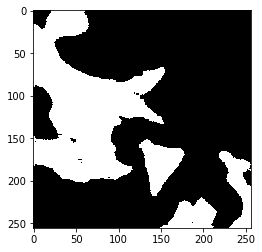

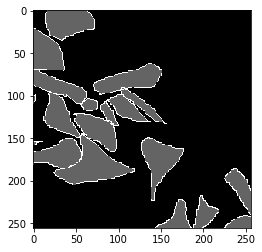

('SAMPLE ', 1)


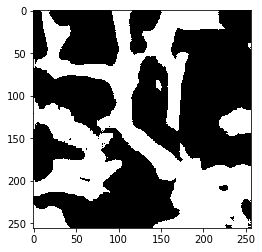

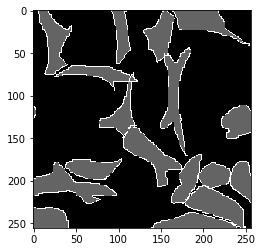

('SAMPLE ', 2)


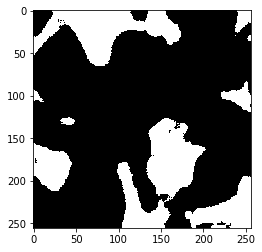

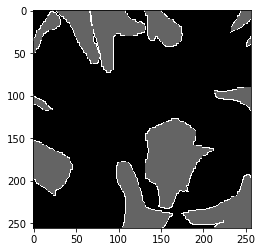

('SAMPLE ', 3)


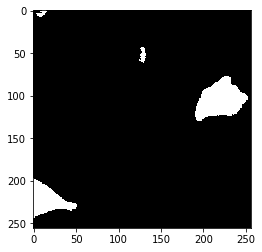

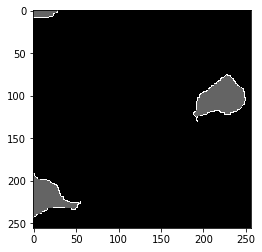

('SAMPLE ', 4)


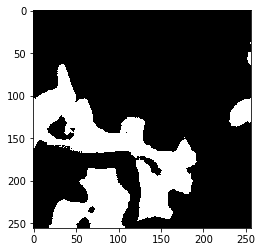

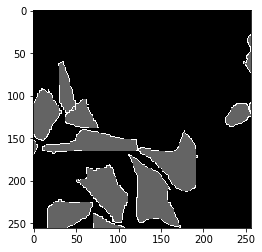

In [13]:
import matplotlib.pyplot as plt

model.eval()
    
loader_iter = iter(test_loader)
for i in range(5):
    data = next(loader_iter)
    
    inputs, labels = data
    inputs = Variable(inputs).cuda()
            
    outputs = model(inputs)            
    
    preds = np.squeeze(np.array(get_predictions(outputs)))
    gt = np.squeeze(np.array(labels))
    
    print('SAMPLE ', i)
    
    preds[np.where(preds == 1)] = 255
    preds[np.where(preds == 2)] = 100
    
    gt[np.where(gt == 1)] = 255
    gt[np.where(gt == 2)] = 100
    
    torch.cuda.empty_cache()
        
    plt.imshow(preds, 'gray')
    plt.show()
    
    plt.imshow(gt, 'gray')
    plt.show()